# [프로젝트] 멀티모달 데이터를 처리하는 RAG- Part 2

질문에 대한 맥락을 검색하여 LLM에 전달하는 RAG는 이미지/표와 같은 데이터를 처리하기 어렵다는 단점이 있습니다.   

Gemini와 같은 멀티모달 모델을 통해, Docling으로 불러온 이미지/표의 정보를 텍스트로 변환해 보겠습니다.

이를 통해, 텍스트 이외에 이미지의 캡션을 포함한 DB를 구성하여 RAG를 수행합니다.

![Image](https://github.com/user-attachments/assets/568ae91a-efb4-4492-bd0b-a492d3e2385c)

**GPU 클라우드 T4를 설정해 주세요!**

In [ ]:
!pip install langchain==1.0.3
!pip install docling langchain_huggingface sentence_transformers jsonlines langchain-google-genai langchain-community beautifulsoup4 langchain_chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.27
    Uninstalling langchain-0.3.27:
      Successfully uninstalled langchain-0.3.27
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.7 MB/s eta 0:00:00
  Prepari

설치 후 세션을 재시작합니다.    

**Gemini 실행을 위해, .env 파일도 업로드해 주세요!**

In [ ]:
import os
import re
import base64
import logging
import time
import uuid
from pathlib import Path
from typing_extensions import TypedDict, List, Dict, Any, Optional, Union, Literal
from dotenv import load_dotenv
from tqdm import tqdm

# 랭그래프 및 랭체인 임포트
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Docling 관련 임포트
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem

# 벡터 저장소 및 임베딩 관련 임포트
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

# LLM 임포트
from langchain_google_genai import ChatGoogleGenerativeAI

# 텍스트 처리 관련 임포트
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from pydantic import BaseModel, Field

# 환경 변수 로드
load_dotenv()

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 상수 정의
IMAGE_RESOLUTION_SCALE = 2.0  # 이미지 해상도 배율
OUTPUT_DIR = "mm_rag_output"  # 출력 디렉토리
CHUNK_SIZE = 4000  # 텍스트 청크 크기
CHUNK_OVERLAP = 400  # 텍스트 청크 오버랩

# 캡션 생성을 위한 앞뒤 컨텍스트 크기(각각)
CONTEXT_BEFORE_SIZE = 2000
CONTEXT_AFTER_SIZE = 2000



# LLM 및 임베딩 모델 초기화
def initialize_models():
    """LLM과 임베딩 모델을 초기화하는 함수"""
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")
    return llm, embeddings

llm, embeddings = initialize_models()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
class ImageItem(TypedDict):
    image_id: str       # 이미지 고유 ID
    path: str           # 이미지 파일 경로
    context_before: str # 이미지 앞 텍스트
    context_after: str  # 이미지 뒤 텍스트
    importance_score: float  # 중요도 점수
    caption: str # 생성된 캡션

class TextChunk(TypedDict):
    chunk_id: str       # 청크 고유 ID
    content: str        # 청크 내용

class State(TypedDict):
    # 문서 정보
    file_path: str  # 파일 경로
    url: str  # 원본 URL (있는 경우)
    md_path: str # 마크다운 파일 경로
    error: str    # 오류 메시지

    # 핵심 콘텐츠
    text_chunks: List[TextChunk]  # 텍스트 청크 목록
    images: List[ImageItem]       # 이미지 목록

    # 상태 관리
    current_step: str    # 현재 처리 단계
    errors: List[str]   # 오류 메시지 목록
    vectordb_path: str  # 벡터DB 저장 경로

# 이미지 중요도 평가 출력 스키마
class ImageImportanceResult(BaseModel):
    """이미지 중요도 평가 결과 스키마"""
    importance_score: float = Field(description="이미지의 중요도 점수 (0.0~1.0)")
    reasoning: str = Field(description="중요도 평가의 근거")
    is_important: bool = Field(description="이미지가 중요한지 여부 (True/False)")

# 이미지 캡션 출력 스키마
class ImageCaptionResult(BaseModel):
    """이미지 캡션 생성 결과 스키마"""
    caption: str = Field(description="이미지에 대한 상세한 설명")
    key_elements: List[str] = Field(description="이미지에서 식별된 주요 요소 목록")

In [ ]:
# 초기 상태 생성 함수
def create_initial_state(file_path: str) -> State:
    """초기 상태를 생성하는 함수"""
    return {
        # 문서 정보
        "file_path": file_path,
        "url": file_path if file_path.startswith("http") else None,
        "md_path": None,
        "error": None,

        # 콘텐츠
        "text_chunks": [],
        "images": [],

        # 상태 관리
        "current_step": "initialized",
        "errors": [],
        "vectordb_path": None
    }

# Docling 문서 처리 함수
def process_document(state: State) -> State:
    """PDF 문서를 처리하여 마크다운 및 이미지로 변환"""
    try:
        doc_path = state["file_path"]
        is_url = doc_path.startswith("http")

        output_dir = Path(OUTPUT_DIR)
        output_dir.mkdir(parents=True, exist_ok=True)

        # 파이프라인 옵션 설정
        pipeline_options = PdfPipelineOptions()
        pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
        pipeline_options.generate_page_images = True
        pipeline_options.generate_picture_images = True

        # 변환기 초기화
        doc_converter = DocumentConverter(
            format_options={InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)}
        )

        # 문서 변환
        logger.info(f"문서 변환 중: {doc_path}")
        if is_url:
            conv_res = doc_converter.convert(doc_path)
        else:
            conv_res = doc_converter.convert(Path(doc_path))

        doc_filename = Path(doc_path).stem if not is_url else doc_path.split("/")[-1].split(".")[0]

        # 마크다운 저장
        md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
        conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

        # 이미지/테이블 저장
        table_counter = 0
        picture_counter = 0
        for element, _level in conv_res.document.iterate_items():
            if isinstance(element, TableItem):
                table_counter += 1
                element_image_filename = output_dir / f"{doc_filename}-table-{table_counter}.png"
                with element_image_filename.open("wb") as fp:
                    element.get_image(conv_res.document).save(fp, "PNG")

            if isinstance(element, PictureItem):
                picture_counter += 1
                element_image_filename = output_dir / f"{doc_filename}-picture-{picture_counter}.png"
                with element_image_filename.open("wb") as fp:
                    element.get_image(conv_res.document).save(fp, "PNG")

        # 상태 업데이트
        state["md_path"] = str(md_filename)
        state["current_step"] = "document_parsed"

        logger.info(f"문서 변환 완료: 테이블 {table_counter}개, 이미지 {picture_counter}개")

    except Exception as e:
        error_msg = f"문서 처리 오류: {str(e)}"
        logger.error(error_msg)
        state["error"] = error_msg
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 텍스트 추출 함수
def extract_text(state: State) -> State:
    """마크다운에서 텍스트 추출하고 청킹"""
    try:
        md_path = state["md_path"]

        if not md_path:
            raise ValueError("마크다운 파일 경로가 없습니다.")

        # 마크다운 파일 읽기
        with open(md_path, 'r', encoding='utf-8') as file:
            markdown_text = file.read()

        # 청크 분할
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=CHUNK_SIZE,
            chunk_overlap=CHUNK_OVERLAP,
        )

        doc = Document(page_content=markdown_text)
        chunks = text_splitter.split_documents([doc])

        # 청크 저장
        text_chunks = []
        for i, chunk in enumerate(chunks):
            chunk_id = f"chunk_{i}"
            text_chunks.append({
                "chunk_id": chunk_id,
                "content": chunk.page_content,
            })

        state["text_chunks"] = text_chunks
        state["current_step"] = "text_extracted"
        logger.info(f"텍스트 추출 완료: {len(text_chunks)}개 청크")

    except Exception as e:
        error_msg = f"텍스트 추출 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 이미지 추출 함수
def extract_images(state: State) -> State:
    """마크다운에서 이미지 태그 및 주변 텍스트 추출"""
    try:
        md_path = state["md_path"]

        if not md_path:
            raise ValueError("마크다운 파일 경로가 없습니다.")

        output_dir = Path(OUTPUT_DIR)

        # 마크다운 파일 읽기
        with open(md_path, 'r', encoding='utf-8') as file:
            markdown_text = file.read()

        # 이미지 태그 추출
        image_pattern = r'!\[.*?\]\((.*?)\)'
        matches = list(re.finditer(image_pattern, markdown_text))

        images = []
        for i, match in enumerate(matches):
            image_path = match.group(1)
            start_index = match.start()
            end_index = match.end()

            # 앞뒤 컨텍스트
            context_before = markdown_text[max(0, start_index - CONTEXT_BEFORE_SIZE):start_index]
            context_after = markdown_text[end_index:min(len(markdown_text), end_index + CONTEXT_AFTER_SIZE)]

            full_path = str(output_dir / image_path)

            images.append({
                "image_id": f"image_{i}",
                "path": full_path,
                "context_before": context_before,
                "context_after": context_after,
                "importance_score": None,
                "caption": None,
            })

        state["images"] = images
        state["current_step"] = "images_extracted"
        logger.info(f"이미지 추출 완료: {len(images)}개 이미지")

    except Exception as e:
        error_msg = f"이미지 추출 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 이미지 필터링 및 중요도 평가 함수
def evaluate_image_importance(state: State) -> State:
    """이미지의 중요도를 평가하고 필터링"""
    try:
        images = state["images"]

        if not images:
            logger.info("평가할 이미지가 없습니다")
            state["current_step"] = "importance_evaluated"
            return state

        importance_llm = llm.with_structured_output(ImageImportanceResult)

        importance_prompt = ChatPromptTemplate([
            ("system", """당신은 문서 내 이미지의 중요도를 평가하는 전문가입니다.
이미지와 주변 문맥을 분석하여 이미지가 얼마나 중요한지 평가해 주세요.
해당 이미지는 이후 캡션을 생성하여 문서의 이해도를 높이는데 사용될 것입니다.

다음 기준으로 이미지의 중요도를 평가하세요:
1. 이미지가 얼마나 정보를 제공하는가?
2. 이미지의 내용이 얼마나 명확한가?
3. 주변의 텍스트만으로는 이해하기 어려운 시각적 정보를 포함하는가?

0.0(전혀 중요하지 않음)부터 1.0(매우 중요함)까지의 점수를 부여하세요.
0.5 이상이면 중요한 이미지로 판단합니다."""),
            ("user", [
                {"type": "text", "text": """이미지와 주변 문맥이 아래에 주어집니다. 이미지의 중요도를 평가해 주세요.

이미지 전 문맥:
{context_before}

이미지 후 문맥:
{context_after}"""},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ])
        ])

        # 이미지 평가 체인
        evaluation_chain = importance_prompt | importance_llm

        updated_images = []
        for image in images:
            try:
                # 이미지 파일이 존재하는지 확인
                if not os.path.exists(image["path"]):
                    logger.warning(f"이미지 파일을 찾을 수 없음: {image['path']}")
                    image["importance_score"] = 0.0
                    updated_images.append(image)
                    continue

                # 이미지 평가
                with open(image["path"], 'rb') as img_file:
                    img_data = base64.b64encode(img_file.read()).decode('utf-8')

                # 이미지 데이터를 메시지에 포함
                input_data = {
                    "context_before": image["context_before"],
                    "context_after": image["context_after"],
                    "image_data": img_data
                }

                # 이미지가 있는 경우에만 평가 수행
                result = evaluation_chain.invoke(input_data)

                # 결과 업데이트
                image["importance_score"] = result.importance_score
                updated_images.append(image)

                logger.info(f"이미지 평가 완료 {image['image_id']}: 점수={result.importance_score}, 중요={result.is_important}")

            except Exception as e:
                logger.error(f"이미지 평가 오류 {image['image_id']}: {str(e)}")
                image["importance_score"] = 0.0
                updated_images.append(image)

        state["images"] = updated_images
        state["current_step"] = "importance_evaluated"

    except Exception as e:
        error_msg = f"이미지 중요도 평가 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 이미지 중요도에 따른 라우팅 함수
def route_by_importance(state: State) -> Literal["generate_captions", "skip_captions"]:
    """중요한 이미지가 있는지 확인하고 경로 결정"""
    images = state["images"]
    important_images = [img for img in images if img.get("importance_score", 0) >= 0.7]

    if important_images:
        logger.info(f"중요 이미지 {len(important_images)}개 발견, 캡션 생성 진행")
        return "generate_captions"
    else:
        logger.info("중요 이미지가 없음, 캡션 생성 건너뜀")
        return "skip_captions"

# 이미지 캡션 생성 함수
def generate_image_captions(state: State) -> State:
    """중요한 이미지에 대해 캡션 생성"""
    try:
        images = state["images"]
        important_images = [img for img in images if img.get("importance_score", 0) >= 0.7]

        if not important_images:
            logger.info("캡션을 생성할 중요 이미지가 없습니다")
            state["current_step"] = "captions_generated"
            return state

        # 구조화된 출력을 위한 LLM 설정
        caption_llm = llm.with_structured_output(ImageCaptionResult)

        # 캡션 생성 프롬프트
        caption_prompt = ChatPromptTemplate([
            ("system", """당신은 학술 자료의 이미지를 분석하고 상세한 캡션을 생성하는 전문가입니다.
이미지와 주변 텍스트를 분석하여 자세하고 정확한 캡션을 작성해 주세요.

다음 항목을 포함한 상세한 캡션을 작성하세요:
1. 이미지가 무엇을 보여주는지 간결하게 설명
2. 주요 요소, 패턴, A부터 B까지 관계 등 중요한 정보 포함
3. 그래프/차트인 경우 주요 추세와 데이터 포인트 설명
4. 이미지가 어떻게 주변 텍스트와 연관되는지 설명
5. 해당 이미지의 시사점 포함
"""),
            ("user",[
                {"type": "text", "text":
"""이미지와 주변 문맥이 아래에 주어집니다. 이 이미지에 대한 상세한 캡션을 생성해 주세요.

이미지 전 문맥:
{context_before}

이미지 후 문맥:
{context_after}"""},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ])
        ])

        # 캡션 생성 체인
        caption_chain = caption_prompt | caption_llm

        updated_images = []
        for image in images:
            if image.get("importance_score", 0) < 0.5:
                updated_images.append(image)
                continue

            try:
                # 이미지 파일이 존재하는지 확인
                if not os.path.exists(image["path"]):
                    logger.warning(f"캡션 생성용 이미지 파일을 찾을 수 없음: {image['path']}")
                    updated_images.append(image)
                    continue

                # 이미지 로드
                with open(image["path"], 'rb') as img_file:
                    img_data = base64.b64encode(img_file.read()).decode('utf-8')

                # 캡션 생성
                input_data = {
                    "context_before": image["context_before"],
                    "context_after": image["context_after"],
                    "image_data": img_data  # 이미지 데이터 추가
                }

                result = caption_chain.invoke(input_data)

                # 결과 업데이트
                image["caption"] = result.caption
                updated_images.append(image)

                logger.info(f"이미지 캡션 생성 완료 {image['image_id']}")

            except Exception as e:
                logger.error(f"이미지 캡션 생성 오류 {image['image_id']}: {str(e)}")
                updated_images.append(image)

        state["images"] = updated_images
        state["current_step"] = "captions_generated"

    except Exception as e:
        error_msg = f"캡션 생성 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 벡터 DB 저장 함수
def store_in_vectordb(state: State) -> State:
    """텍스트 청크와 이미지 캡션을 벡터 DB에 저장"""
    try:
        # 텍스트 청크와 이미지 캡션을 모두 포함하는 문서 목록 생성
        documents = []

        # 텍스트 청크 추가
        for chunk in state["text_chunks"]:
            doc = Document(
                page_content=chunk["content"],
                metadata={
                    "chunk_id": chunk["chunk_id"],
                    "type": "text"
                }
            )
            documents.append(doc)

        # 이미지 캡션 추가
        for image in state["images"]:
            if image.get("caption"):
                doc = Document(
                    page_content=image["caption"],
                    metadata={
                        "image_id": image["image_id"],
                        "type": "image",
                        "path": image["path"]
                    }
                )
                documents.append(doc)

        # 문서가 없는 경우 임시 문서 추가 (벡터 DB 오류 방지)
        if not documents:
            dummy_doc = Document(
                page_content="No content available",
                metadata={"type": "dummy"}
            )
            documents.append(dummy_doc)

        # 랜덤 UUID로 DB 경로 생성
        db_uuid = uuid.uuid4().hex[:8]
        db_path = f"DB_{db_uuid}"
        os.makedirs(db_path, exist_ok=True)

        # 먼저 빈 Chroma 인스턴스 생성 (영구 저장소 지정)
        vector_store = Chroma(
            collection_name="mmrag_collection",
            embedding_function=embeddings,
            persist_directory=db_path
        )

        # 문서 추가 (자동으로 디스크에 저장됨)
        # 10개씩 추가
        for i in tqdm(range(0, len(documents), 10)):
            vector_store.add_documents(documents[i:min(i+10, len(documents))])

        state["vectordb_path"] = db_path
        state["current_step"] = "vectordb_stored"
        logger.info(f"벡터 DB 저장 완료: {len(documents)}개 문서, 경로: {db_path}")

    except Exception as e:
        error_msg = f"벡터 DB 저장 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

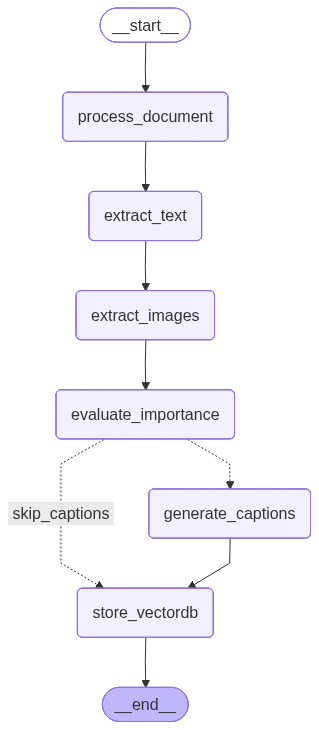

In [ ]:
# 그래프 구축
def build_graph():

    builder = StateGraph(State)

    builder.add_node("process_document", process_document)
    builder.add_node("extract_text", extract_text)
    builder.add_node("extract_images", extract_images)
    builder.add_node("evaluate_importance", evaluate_image_importance)
    builder.add_node("generate_captions", generate_image_captions)
    builder.add_node("store_vectordb", store_in_vectordb)

    builder.add_edge(START, "process_document")
    builder.add_edge("process_document", "extract_text")
    builder.add_edge("extract_text", "extract_images")
    builder.add_edge("extract_images", "evaluate_importance")


    builder.add_conditional_edges(
        "evaluate_importance",
        route_by_importance,
        {
            "generate_captions": "generate_captions",
            "skip_captions": "store_vectordb"
        }
    )

    builder.add_edge("generate_captions", "store_vectordb")
    builder.add_edge("store_vectordb", END)

    return builder

builder = build_graph()
graph = builder.compile()
graph

In [ ]:
# PDF를 처리하고 벡터 DB를 생성하는 메인 함수
def process_pdf_to_vectordb(pdf_path: str) -> str:
    """
    PDF 파일을 처리하여 벡터 DB를 생성하는 함수

    Args:
        pdf_path (str): PDF 파일의 경로 또는 URL

    Returns:
        str: 생성된 벡터 DB의 경로
        Dict[str, str]: 생성된 벡터 DB 정보 (경로 및 컬렉션 이름)
    """
    logger.info(f"PDF 처리 시작: {pdf_path}")

    # 초기 상태 생성
    initial_state = create_initial_state(pdf_path)

    # 그래프 실행
    final_state = graph.invoke(initial_state)

    # 결과 확인
    if final_state["current_step"] == "vectordb_stored" and final_state["vectordb_path"]:
        result_path = final_state["vectordb_path"]
        logger.info(f"PDF 처리 완료, 벡터 DB 경로: {result_path}")

        # 처리 통계 출력
        text_chunks_count = len(final_state["text_chunks"])
        images_count = len(final_state["images"])
        captioned_images = sum(1 for img in final_state["images"] if img.get("caption"))

        logger.info(f"처리 통계: 텍스트 청크 {text_chunks_count}개, 이미지 {images_count}개, 캡션 생성된 이미지 {captioned_images}개")

        return {
            "db_path": result_path,
            "collection_name": "mmrag_collection"
        }

    else:
        error_msg = f"PDF 처리 실패: {final_state['errors']}"
        logger.error(error_msg)
        raise RuntimeError(error_msg)


In [ ]:
pdf_path = "https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf"
result = process_pdf_to_vectordb(pdf_path)
db_path, collection_name = result["db_path"], result["collection_name"]

[INFO] 2025-11-02 06:34:43,944 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-02 06:34:43,972 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-02 06:34:43,973 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-02 06:34:44,108 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-02 06:34:44,115 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-02 06:34:44,117 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-02 06:34:44,191 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-02 06:34:44,246 [RapidOCR] download_file.py:60: File exists and is valid: /usr/loc

len(pages)=1, 0-0
len(valid_pages)=1
len(valid_page_images)=1


[INFO] 2025-11-02 06:35:07,902 [RapidOCR] download_file.py:68: Initiating download: https://www.modelscope.cn/models/RapidAI/RapidOCR/resolve/v3.4.0/resources/fonts/FZYTK.TTF
[INFO] 2025-11-02 06:35:09,726 [RapidOCR] download_file.py:82: Download size: 3.09MB
[INFO] 2025-11-02 06:35:10,082 [RapidOCR] download_file.py:95: Successfully saved to: /usr/local/lib/python3.12/dist-packages/rapidocr/models/FZYTK.TTF


len(pages)=1, 1-1
len(valid_pages)=1
len(valid_page_images)=1
len(pages)=4, 2-5
len(valid_pages)=4
len(valid_page_images)=4
len(pages)=4, 6-9
len(valid_pages)=4
len(valid_page_images)=4
len(pages)=4, 10-13
len(valid_pages)=4
len(valid_page_images)=4
len(pages)=4, 14-17
len(valid_pages)=4
len(valid_page_images)=4
len(pages)=4, 18-21
len(valid_pages)=4
len(valid_page_images)=4
len(pages)=3, 22-24
len(valid_pages)=3
len(valid_page_images)=3


100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


In [ ]:
db_path,collection_name

('DB_984b4c8f', 'mmrag_collection')

생성된 DB를 통해 검색을 수행해 보겠습니다.

In [ ]:
db = Chroma(embedding_function=embeddings, collection_name=collection_name, persist_directory=db_path)

retriever = db.as_retriever(search_kwargs={"k": 6})
retriever.invoke(input= "Gemma 3의 성능 향상 방법은 무엇인가요?")


[Document(id='e55a6159-f3af-4f63-8590-92e352ea1a59', metadata={'image_id': 'image_2', 'type': 'image', 'path': 'mm_rag_output/mm_rag_output/Gemma3Report-with-image-refs_artifacts/image_000002_ebdb9c4b21046339cc8166213c569aca08f2b2710e0745ae8af939c7a9b2b832.png'}, page_content='이 이미지는 Gemma 2 및 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력에 대한 성능 요약을 보여주는 세 개의 레이더 차트를 보여줍니다. 각 차트는 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 여섯 가지 범주에 대한 모델의 성능을 나타냅니다. 첫 번째 차트는 Gemma 2 2B 모델과 Gemma 3 4B 모델의 성능을 비교하고, 두 번째 차트는 Gemma 2 9B 모델과 Gemma 3 12B 모델의 성능을 비교하고, 세 번째 차트는 Gemma 2 27B 모델과 Gemma 3 27B 모델의 성능을 비교합니다. 일반적으로 Gemma 3 모델은 Gemma 2 모델보다 모든 범주에서 더 나은 성능을 보입니다. Gemma 3 모델은 다국어 능력에서 가장 큰 개선을 보입니다.'),
 Document(id='7d194ec4-6e54-4454-9c38-abe7417adf25', metadata={'chunk_id': 'chunk_0', 'type': 'text'}, page_content='![Image](mm_rag_output/Gemma3Report-with-image-refs_artifacts/image_000000_ed786dc638fedbddb22c1f0c1f1f9751d5fd779a0e770039a5af911993729014.png)\n\n## Gemma 3 Technical Report\n\nGemma Team, Google DeepMind 1\n\nW

RAG도 그대로 수행할 수 있습니다.

In [ ]:
# 테스트 쿼리
test_queries = [
    "Gemma 3의 주요 특징은 무엇인가요?",
    "Gemma 3의 성능 평가 결과를 설명해주세요.",
    "Gemma 3의 멀티모달 능력은 어떻게 되나요?",
    "Gemma 3의 Technical Report에서 활용하는 주요 벤치마크는 무엇인가요?",
    "Gemma 3의 성능이나 구현, 운영 상에서의 한계점이나 이후 발전 방향은 무엇인가요?"
]

# 평가 실행
prompt = ChatPromptTemplate([
    ("user", '''당신은 QA(Question-Answering)을 수행하는 Assistant입니다.
다음의 Context를 이용하여 Question에 한국어로 답변하세요.
정확한 답변을 제공하세요.
만약 모든 Context를 다 확인해도 정보가 없다면, "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
---
Context: {context}
---
Question: {question}''')])

chain = prompt | llm

def simple_rag(query):

    print(f"\n질문 : {query}")
    context_documents = retriever.invoke(query)

    context = " \n---\n ".join([doc.page_content for doc in context_documents])
    types = [doc.metadata.get("type") for doc in context_documents]

    print(f"검색된 문서 유형: {types}")
    #print(f"검색된 문서 내용: {context}")

    result = chain.invoke({"context": context, "question": query})
    print(f"응답: {result.content}")

for query in test_queries:
    simple_rag(query)



질문 : Gemma 3의 주요 특징은 무엇인가요?
검색된 문서 유형: ['image', 'text', 'image', 'text', 'text', 'text']
응답: Gemma 3의 주요 특징은 다음과 같습니다:

*   **멀티모달:** Gemma 3 모델은 이미지 이해 능력을 갖추고 있습니다.
*   **긴 컨텍스트:** Gemma 3 모델은 128K 토큰의 컨텍스트 길이를 지원합니다 (1B 모델은 32K).
*   **다국어:** Gemma 3 모델은 향상된 다국어 능력을 제공합니다.

질문 : Gemma 3의 성능 평가 결과를 설명해주세요.
검색된 문서 유형: ['image', 'text', 'text', 'image', 'text', 'text']
응답: Gemma 3 모델은 다양한 벤치마크에서 Gemma 2 모델보다 향상된 성능을 보입니다. 특히 다국어 능력에서 가장 큰 개선을 보입니다. Chatbot Arena 평가에서 Gemma-3-27B-IT 모델은 DeepSeek-V3, LLaMA 3 405B, Qwen2.5-70B와 같은 더 큰 모델보다 높은 순위를 기록했습니다. Gemma 3 IT 모델은 비전 이해 벤치마크에서도 좋은 성능을 보이며, Perception Test MCVQA 및 ActivityNet-QA에서 4B, 12B, 27B 모델 모두 우수한 결과를 나타냈습니다. 또한, 긴 문맥 벤치마크인 RULER와 MRCR에서도 좋은 성능을 보입니다.

질문 : Gemma 3의 멀티모달 능력은 어떻게 되나요?
검색된 문서 유형: ['image', 'text', 'text', 'text', 'text', 'text']
응답: Gemma 3 모델은 멀티모달 기능을 갖추고 있으며, 대부분의 모델이 SigLIP 비전 인코더의 맞춤 버전을 지원합니다. 언어 모델은 이미지를 SigLIP에 의해 인코딩된 소프트 토큰 시퀀스로 취급하며, 비전 임베딩을 고정된 크기의 256개 벡터로 압축하여 이미지 처리의 추론 비용을 줄입니다.

질문 : Gemma 3의 Te

답변과 함께, 검색된 이미지를 같이 보여준다면 어떨까요?


질문 : Gemma 3의 주요 특징은 무엇인가요?
검색된 문서 유형: ['image', 'text', 'image', 'text', 'text', 'text']
응답: Gemma 3의 주요 특징은 다음과 같습니다:
1. 멀티모달 지원: 이미지 이해 능력이 추가되었습니다.
2. 긴 컨텍스트 지원: 최소 128K 토큰의 컨텍스트 길이를 지원합니다.
3. 다국어 능력 향상: 다양한 언어에 대한 지원이 확대되었습니다.
검색된 이미지:


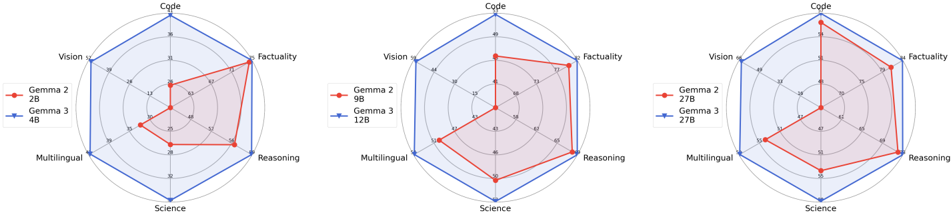

이미지 설명: 이 이미지는 Gemma 2 및 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력에 대한 성능 요약을 보여주는 세 개의 레이더 차트를 보여줍니다. 각 차트는 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 여섯 가지 범주에 대한 모델의 성능을 나타냅니다. 첫 번째 차트는 Gemma 2 2B 모델과 Gemma 3 4B 모델의 성능을 비교하고, 두 번째 차트는 Gemma 2 9B 모델과 Gemma 3 12B 모델의 성능을 비교하고, 세 번째 차트는 Gemma 2 27B 모델과 Gemma 3 27B 모델의 성능을 비교합니다. 일반적으로 Gemma 3 모델은 Gemma 2 모델보다 모든 범주에서 더 나은 성능을 보입니다. Gemma 3 모델은 다국어 능력에서 가장 큰 개선을 보입니다.


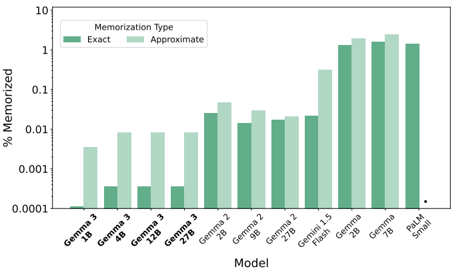

이미지 설명: 이 그래프는 다양한 모델에 대한 총 암기율을 보여줍니다. x축은 모델 이름(예: Gemma 3 1B, Gemma 3 4B, Gemma 2 2B)을 나타내고, y축은 로그 스케일로 표시된 암기된 비율(%)을 나타냅니다. 녹색 막대는 정확한 암기율을 나타내고, 밝은 녹색 막대는 대략적인 암기율을 나타냅니다. Gemma 3 모델은 이전 모델보다 암기율이 훨씬 낮습니다. 대략적인 암기는 정확한 암기보다 더 일반적입니다.

질문 : Gemma 3의 성능 평가 결과를 설명해주세요.
검색된 문서 유형: ['image', 'text', 'text', 'image', 'text', 'text']
응답: Gemma 3는 다양한 벤치마크에서 성능이 평가되었습니다. 주요 내용은 다음과 같습니다:

*   **일반적인 능력:** Gemma 3 모델은 Gemma 2 모델보다 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 모든 범주에서 더 나은 성능을 보입니다. 특히 다국어 능력에서 가장 큰 개선을 보입니다.
*   **Chatbot Arena:** Chatbot Arena에서 Gemma 3 27B IT 모델은 DeepSeek-V3, LLaMA 3 405B, Qwen2.5-70B와 같은 다른 대형 오픈 모델보다 높은 Elo 점수를 받았습니다. Gemma 3의 Elo 점수는 Gemma 2보다 상당히 높습니다.
*   **표준 벤치마크:** MMLU, MBPP, HumanEval, N2C, LiveCodeBench, GSM8K, MATH 등 다양한 벤치마크에서 Gemma 3 모델은 Gemma 2 모델과 비교하여 향상된 성능을 보입니다.
*   **비전 이해:** Gemma 3 IT 모델은 Perception Test MCVQA 및 ActivityNet-QA 벤치마크에서 평가되었으며, 다양한 모델 크기(4B, 12B, 27B)에 따른 성능이 측정되었습니다.
*   **다국어 벤치마크:** XQuAD, XORQA, Flores Indic와 같은 다국어 벤치마크에서 Gemma

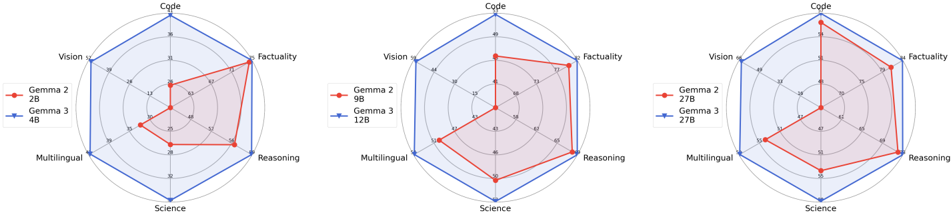

이미지 설명: 이 이미지는 Gemma 2 및 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력에 대한 성능 요약을 보여주는 세 개의 레이더 차트를 보여줍니다. 각 차트는 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 여섯 가지 범주에 대한 모델의 성능을 나타냅니다. 첫 번째 차트는 Gemma 2 2B 모델과 Gemma 3 4B 모델의 성능을 비교하고, 두 번째 차트는 Gemma 2 9B 모델과 Gemma 3 12B 모델의 성능을 비교하고, 세 번째 차트는 Gemma 2 27B 모델과 Gemma 3 27B 모델의 성능을 비교합니다. 일반적으로 Gemma 3 모델은 Gemma 2 모델보다 모든 범주에서 더 나은 성능을 보입니다. Gemma 3 모델은 다국어 능력에서 가장 큰 개선을 보입니다.


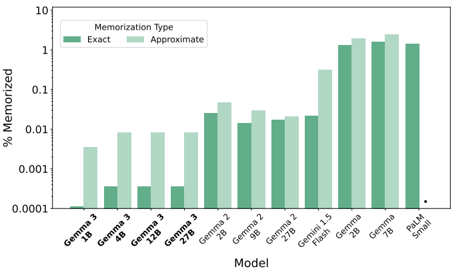

이미지 설명: 이 그래프는 다양한 모델에 대한 총 암기율을 보여줍니다. x축은 모델 이름(예: Gemma 3 1B, Gemma 3 4B, Gemma 2 2B)을 나타내고, y축은 로그 스케일로 표시된 암기된 비율(%)을 나타냅니다. 녹색 막대는 정확한 암기율을 나타내고, 밝은 녹색 막대는 대략적인 암기율을 나타냅니다. Gemma 3 모델은 이전 모델보다 암기율이 훨씬 낮습니다. 대략적인 암기는 정확한 암기보다 더 일반적입니다.

질문 : Gemma 3의 멀티모달 능력은 어떻게 되나요?
검색된 문서 유형: ['image', 'text', 'text', 'text', 'text', 'text']
응답: Gemma 3 모델은 멀티모달 능력을 갖추고 있으며, 대부분의 모델이 SigLIP vision encoder의 맞춤 버전을 사용합니다. 언어 모델은 이미지를 SigLIP에 의해 인코딩된 소프트 토큰 시퀀스로 처리하며, 이미지 처리의 추론 비용을 줄이기 위해 비전 임베딩을 256 벡터의 고정 크기로 압축합니다.
검색된 이미지:


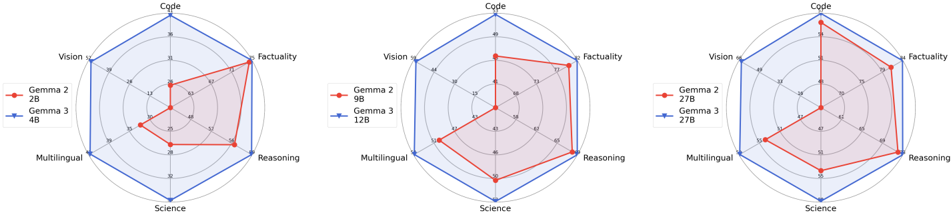

이미지 설명: 이 이미지는 Gemma 2 및 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력에 대한 성능 요약을 보여주는 세 개의 레이더 차트를 보여줍니다. 각 차트는 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 여섯 가지 범주에 대한 모델의 성능을 나타냅니다. 첫 번째 차트는 Gemma 2 2B 모델과 Gemma 3 4B 모델의 성능을 비교하고, 두 번째 차트는 Gemma 2 9B 모델과 Gemma 3 12B 모델의 성능을 비교하고, 세 번째 차트는 Gemma 2 27B 모델과 Gemma 3 27B 모델의 성능을 비교합니다. 일반적으로 Gemma 3 모델은 Gemma 2 모델보다 모든 범주에서 더 나은 성능을 보입니다. Gemma 3 모델은 다국어 능력에서 가장 큰 개선을 보입니다.

질문 : Gemma 3의 Technical Report에서 활용하는 주요 벤치마크는 무엇인가요?
검색된 문서 유형: ['image', 'image', 'image', 'text', 'text', 'text']
응답: Gemma 3의 Technical Report에서 활용하는 주요 벤치마크는 다음과 같습니다: MMLU, MBPP, HumanEval, N2C, LiveCodeBench, GSM8K, MATH, HiddenMath, BBH, BBEH, IFEval, GMMLU-Lite, ECLeKTic, WMT24 ++, Perception Test MCVQA, ActivityNet-QA.
검색된 이미지:


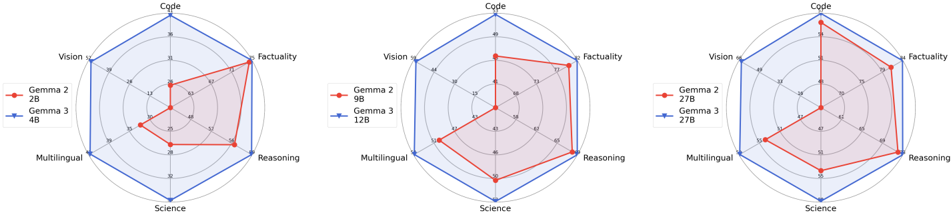

이미지 설명: 이 이미지는 Gemma 2 및 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력에 대한 성능 요약을 보여주는 세 개의 레이더 차트를 보여줍니다. 각 차트는 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 여섯 가지 범주에 대한 모델의 성능을 나타냅니다. 첫 번째 차트는 Gemma 2 2B 모델과 Gemma 3 4B 모델의 성능을 비교하고, 두 번째 차트는 Gemma 2 9B 모델과 Gemma 3 12B 모델의 성능을 비교하고, 세 번째 차트는 Gemma 2 27B 모델과 Gemma 3 27B 모델의 성능을 비교합니다. 일반적으로 Gemma 3 모델은 Gemma 2 모델보다 모든 범주에서 더 나은 성능을 보입니다. Gemma 3 모델은 다국어 능력에서 가장 큰 개선을 보입니다.


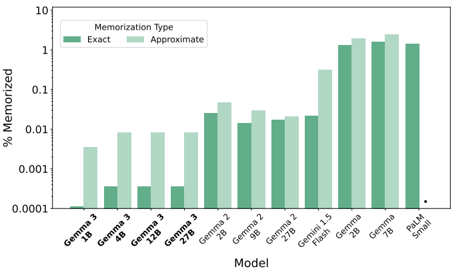

이미지 설명: 이 그래프는 다양한 모델에 대한 총 암기율을 보여줍니다. x축은 모델 이름(예: Gemma 3 1B, Gemma 3 4B, Gemma 2 2B)을 나타내고, y축은 로그 스케일로 표시된 암기된 비율(%)을 나타냅니다. 녹색 막대는 정확한 암기율을 나타내고, 밝은 녹색 막대는 대략적인 암기율을 나타냅니다. Gemma 3 모델은 이전 모델보다 암기율이 훨씬 낮습니다. 대략적인 암기는 정확한 암기보다 더 일반적입니다.


이미지 설명: 이 이미지는 Google DeepMind 로고를 보여줍니다. 이 로고는 Google이라는 단어가 파란색, 빨간색, 노란색, 녹색으로 표시되어 있고 그 옆에 DeepMind라는 단어가 회색으로 표시되어 있습니다. 이 이미지는 Gemma 3 기술 보고서의 저자를 나타냅니다.

질문 : Gemma 3의 성능이나 구현, 운영 상에서의 한계점이나 이후 발전 방향은 무엇인가요?
검색된 문서 유형: ['image', 'text', 'text', 'text', 'image', 'text']
응답: Gemma 3의 한계점 및 향후 발전 방향에 대한 직접적인 정보는 제공되지 않습니다. 하지만 문서에서 다음과 같은 내용을 확인할 수 있습니다.

*   **책임, 안전, 보안:** Gemma 모델 개발에서 책임, 안전, 보안이 가장 중요하며, Gemma 3 사용자 위험을 줄이기 위해 강화된 내부 안전 프로세스를 통합했습니다.
*   **거버넌스 및 평가:** Gemma의 이점과 위험을 평가하는 접근 방식은 Gemma 1과 유사하며, 지원되는 modality의 변화를 고려합니다.
*   **안전 정책 및 훈련 시 완화:** fine-tuning된 모델을 Google의 안전 정책에 맞추고, 유해 콘텐츠 생성을 방지하도록 설계되었습니다.
*   **보증 평가:** 새로운 image-to-text 기능에 대한 안전 완화 및 강력하고 투명한 모델 평가에 중점을 둡니다.

이 정보는 Gemma 3가 안전과 책임에 중점을 두고 개발되었으며, 잠재적 위험을 줄이기 위한 노력이 계속되고 있음을 시사합니다. 그러나 구체적인 한계점이나 향후 개선 방향에 대한 자세한 내용은 찾을 수 없습니다.
검색된 이미지:


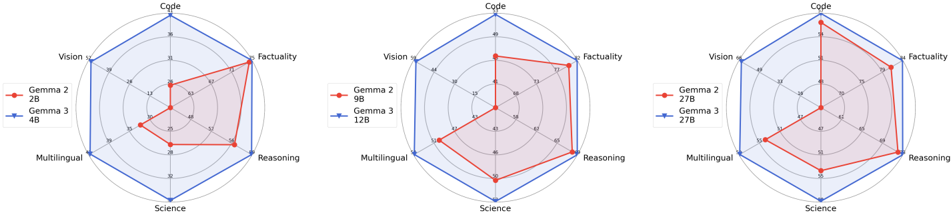

이미지 설명: 이 이미지는 Gemma 2 및 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력에 대한 성능 요약을 보여주는 세 개의 레이더 차트를 보여줍니다. 각 차트는 코드, 사실성, 비전, 추론, 과학, 다국어 능력의 여섯 가지 범주에 대한 모델의 성능을 나타냅니다. 첫 번째 차트는 Gemma 2 2B 모델과 Gemma 3 4B 모델의 성능을 비교하고, 두 번째 차트는 Gemma 2 9B 모델과 Gemma 3 12B 모델의 성능을 비교하고, 세 번째 차트는 Gemma 2 27B 모델과 Gemma 3 27B 모델의 성능을 비교합니다. 일반적으로 Gemma 3 모델은 Gemma 2 모델보다 모든 범주에서 더 나은 성능을 보입니다. Gemma 3 모델은 다국어 능력에서 가장 큰 개선을 보입니다.


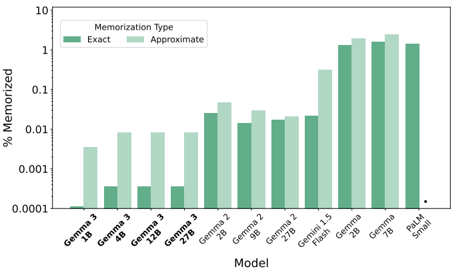

이미지 설명: 이 그래프는 다양한 모델에 대한 총 암기율을 보여줍니다. x축은 모델 이름(예: Gemma 3 1B, Gemma 3 4B, Gemma 2 2B)을 나타내고, y축은 로그 스케일로 표시된 암기된 비율(%)을 나타냅니다. 녹색 막대는 정확한 암기율을 나타내고, 밝은 녹색 막대는 대략적인 암기율을 나타냅니다. Gemma 3 모델은 이전 모델보다 암기율이 훨씬 낮습니다. 대략적인 암기는 정확한 암기보다 더 일반적입니다.


In [ ]:
from IPython.display import Image, Markdown, display

def simple_rag_with_image(query):
    print(f"\n질문 : {query}")
    context_documents = retriever.invoke(query)

    context = " \n---\n ".join([doc.page_content for doc in context_documents])
    types = [doc.metadata.get("type") for doc in context_documents]

    print(f"검색된 문서 유형: {types}")
    #print(f"검색된 문서 내용: {context}")

    result = chain.invoke({"context": context, "question": query})
    print(f"응답: {result.content}")

    print("검색된 이미지:")
    for doc in context_documents:
        if doc.metadata.get("type") == "image":
            img = doc.metadata['path']
            display(Image(img))
            print(f"이미지 설명: {doc.page_content}")

for query in test_queries:
    simple_rag_with_image(query)
